# Pneumothorax segmentation with enhanced U-net with EfficientNetB4 Encoder

Implementation of top 7% model during SIIM-ACR Pneumothorax Segmentation Kaggle competition. It scores 0.8413 (dice loss) on private leaderboard.

At the end there is an implementation of an ensembling model.

Only the inference code is present here. (You can play with this notebook on Google Colab).


The code was coded or adapted by Guillaume Balezo.

<img src='https://raw.githubusercontent.com/GuillaumeBalezo/Pneumothorax-Segmentation/master/Images/Images-Results.png' width="600" height="500">

## (Optional) If using Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# work only with tensorflow v1
%tensorflow_version 1.x

In [0]:
# the version is very important
!pip install -q efficientnet==0.0.4

In [0]:
repo_path = '/content/drive/My\ Drive/Kaggle\ -\ Pneumothorax\ Segmentation/'

## Set paths, unzip files and imports

In [0]:
repo_path_python = '/content/drive/My Drive/Kaggle - Pneumothorax Segmentation/'

In [0]:
import numpy as np
import pandas as pd
import keras
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy

from keras import Model
from keras.layers import Conv2DTranspose, concatenate, BatchNormalization
from keras.layers import Dropout, MaxPooling2D
from keras.layers import LeakyReLU, Add, Conv2D
import cv2
from tqdm import tqdm_notebook as tqdm
import glob2
import os
from PIL import Image
from efficientnet import EfficientNetB4
from zipfile import ZipFile
    
%matplotlib inline

Using TensorFlow backend.


In [0]:
if not os.path.isdir('dataset'):
  os.mkdir('dataset')

with ZipFile(repo_path_python + 'train_512.zip', 'r') as zipObj:
   zipObj.extractall('dataset/train')

with ZipFile(repo_path_python + 'test_512.zip', 'r') as zipObj:
   zipObj.extractall('dataset/test')

with ZipFile(repo_path_python + 'masks_512.zip', 'r') as zipObj:
   zipObj.extractall('dataset/masks')

In [0]:
if tf.test.is_gpu_available(cuda_only=True):
  print('working on gpu')
else:
  print('warning: working on cpu')
print(tf.__version__)
print(keras.__version__)

working on gpu
1.15.0
2.2.5


In [0]:
def rle(mask):
  """ Compute the run-length encoding of the mask in order to compress 
  the predictions and make submissions on Kaggle.
  This function was adapted from https://www.kaggle.com/shingchan/fast-rle-with-pure-numpy
  and is way faster than the rle function provided by Kaggle
    Inputs: 
          mask (np.array): masks predicted
    Outputs:
          rle (str): run-length encoding of the mask
  """
  if not np.any(mask):
    return -1 # for empty mask predicted Kaggle want -1 as encoding

  else:
    mask = mask.reshape(-1, order='F')
    mask = np.concatenate(([False], mask, [False]))
    edges = mask[1:] ^ mask[:-1]
    idxs = np.flatnonzero(edges)  # start-end indices
    idxs[1::2] = idxs[1::2] - idxs[0::2]  # replace 'end' by 'run'
    save_1 = idxs[0]

    # this step is used in order to have the specific RLE asked by Kaggle"
    for i in range(2, len(idxs), 2):
      save_2 = idxs[i]
      idxs[i] = idxs[i] - idxs[i-1] - save_1
      save_1 = save_2
  return ' '.join(map(str, idxs.tolist()))

def plot_preds(fns, preds, max_images = 64):
  """ Plot nb_max random predictions.
    Inputs: 
          fns (list of str): image paths associated with the predictions
          preds (np.array): masks predicted
          Optional: max_images (int): nb max of images to display
  """
  training_set = False
  if fns[0].split('/')[1] == 'train':
    training_set = True

  img_size = 128
  grid_width = 16
  grid_height = int(max_images / grid_width)
  fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
  order = list(np.random.permutation(len(fns))[: max_images])
  for i, idx in enumerate(order):
    fn = fns[idx]
    img = cv2.resize(np.array(Image.open(fn)),(img_size, img_size))
    pred = cv2.resize(preds[idx].squeeze(),(img_size, img_size))
    if training_set:
      mask = cv2.resize(np.array(Image.open(fn.replace('train/', 'masks/')), dtype = np.uint8),(img_size, img_size)) > 0
    img = np.clip(img, 0, 255)
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(pred.astype(np.float32), alpha=0.75, cmap="Reds")
    if training_set:
      ax.imshow(mask, alpha=0.4, cmap="Greens")
    ax.axis('off')

def preds_to_csv(fns, preds):
  """ Transform predictions mask with Run-length encoding and save them into csv file.
    Inputs:
          fns: (list of str): image paths associated with the predictions
          preds (np.array): masks predicted
  """
  rles = []
  for p in tqdm(preds):
    rles.append(rle(p))
  ids = [fn.split('/')[-1][:-4] for fn in fns]
  sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
  sub_df.head()
  df_name = 'preds_' + datetime.now().strftime("%d_%m_%Y_%H:%M:%S") + '.csv' # in order to identify the .csv after predictions
  sub_df.to_csv(df_name, index=False)

In [0]:
def UEfficientNet(param):
  """ UEfficientNet Keras implementation.
  The code was taken from https://www.kaggle.com/meaninglesslives/nested-unet-with-efficientnet-encoder
    Inputs: 
          param: dict contening the hyperparameters of the model
    Outputs:
          model: keras model
  """
  imsz = param['imgsize']
  dropout_rate = param['dropout_rate']
  backbone = EfficientNetB4(weights=None, include_top=False, input_shape = (imsz, imsz, 3))
  
  input = backbone.input
  start_neurons = 8

  conv4 = backbone.layers[342].output
  conv4 = LeakyReLU(alpha=0.1)(conv4)
  pool4 = MaxPooling2D((2, 2))(conv4)
  pool4 = Dropout(dropout_rate)(pool4)
    
  # Middle
  convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
  convm = residual_block(convm,start_neurons * 32)
  convm = residual_block(convm,start_neurons * 32)
  convm = LeakyReLU(alpha=0.1)(convm)
    
  deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
  deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
  deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
  deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
  uconv4 = concatenate([deconv4, conv4])
  uconv4 = Dropout(dropout_rate)(uconv4)
    
  uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
  uconv4 = residual_block(uconv4,start_neurons * 16)
  uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
  deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
  deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
  deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
  conv3 = backbone.layers[154].output
  uconv3 = concatenate([deconv3,deconv4_up1, conv3])
  uconv3 = Dropout(dropout_rate)(uconv3)
    
  uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
  uconv3 = residual_block(uconv3,start_neurons * 8)
  uconv3 = LeakyReLU(alpha=0.1)(uconv3)

  deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
  deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
  conv2 = backbone.layers[92].output
  uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
  uconv2 = Dropout(0.1)(uconv2)
  uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
  uconv2 = residual_block(uconv2,start_neurons * 4)
  uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
  deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
  conv1 = backbone.layers[30].output
  uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
  uconv1 = Dropout(0.1)(uconv1)
  uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
  uconv1 = residual_block(uconv1,start_neurons * 2)
  uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
  uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
  uconv0 = Dropout(0.1)(uconv0)
  uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
  uconv0 = residual_block(uconv0,start_neurons * 1)
  uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
  uconv0 = Dropout(dropout_rate/2)(uconv0)
  output_layer = Conv2D(1, (1,1), padding="same", activation='sigmoid')(uconv0)
    
  model = Model(input, output_layer)
  model.name = 'u++-efficientnet'

  model.load_weights(param['weights_path'])
  if not param['loss']:
    model.trainable = False
  else:
    model.compile(loss = param['loss'], optimizer='adam')
  return model

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
  """ 
  Recurrent block in the Unet architecture.
  """
  x = Conv2D(filters, size, strides=strides, padding = padding)(x)
  x = BatchNormalization()(x)
  if activation == True:
    x = LeakyReLU(alpha=0.1)(x)
  return x

def residual_block(blockInput, num_filters=16):
  """ 
  Recurrent block in the Unet architecture.
  """
  x = LeakyReLU(alpha=0.1)(blockInput)
  x = BatchNormalization()(x)
  blockInput = BatchNormalization()(blockInput)
  x = convolution_block(x, num_filters, (3,3) )
  x = convolution_block(x, num_filters, (3,3), activation=False)
  x = Add()([x, blockInput])
  return x

In [0]:
class InferenceGenerator(keras.utils.Sequence):
  """ Generates inputs for the Keras model during inference. It allows to avoid RAM issues at 
  test time and icrease the inference time.
        Attributes: - batch_size (int): batch size during inference
                    - fns (list of str): paths of the images
                    - img_size (int): shape of the inputs of the model
                    - horizontal_flip (bool): True if horizontal flip is applied to the inputs (only if TTA)
                    - indexes (np.array): indexes used for splitting the dataset in batches
        Functions:
                    - __init__
                    - __len__
                    - __get_item__
                    - data_generation
  """
  def __init__(self, fns, param, horizontal_flip = False):
    self.batch_size = param['batch_size']
    self.fns = fns
    self.img_size = param['imgsize']
    self.horizontal_flip = horizontal_flip
    self.indexes = np.arange(len(fns))

  def __len__(self):
    """
    Denotes the number of batches per epoch
    """
    return int(np.ceil(len(self.fns) / self.batch_size))

  def __getitem__(self, index):
    """
    Generate one batch of data'
    """
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.fns))]

    # Find list of IDs
    list_IDs_im = [self.fns[k] for k in indexes]
    
    # Generate data
    X = self.data_generation(list_IDs_im)

    if self.horizontal_flip:
      X = np.array([np.fliplr(x) for x in X])
        
    return X

  def data_generation(self, list_IDs_im):
    """
    Generates data containing batch_size samples
    """
    # Initialization
    X = np.empty((len(list_IDs_im),self.img_size,self.img_size, 3))
    # load data
    for i, fn in enumerate(list_IDs_im):
      img = np.array(Image.open(fn))
      if len(img.shape)==2:
        img = np.repeat(img[...,None],3,2)
        # Resize sample
        img = cv2.resize(img,(self.img_size, self.img_size))
        X[i,] = img

    return X

## Pneumothorax Model

Best Model: 
- Trained on 512x512px images
- Test Time augmentation
- Sigmoid thresold 0.5
- Score of 0.8413 (dice loss) on private leaderboard

<img src='https://raw.githubusercontent.com/GuillaumeBalezo/Pneumothorax-Segmentation/master/Images/Schema.png' width="700" height="500">

In [0]:
class PneumothoraxModel:
  """ Pneumothorax best single model
        Attributes: - param (dict): hyperparameters of the model
                    - model: keras model
        Functions:  - __init__
                    - predict
  """

  def __init__(self, weights_path = './weights/best_model_weights.model'):
    """ Inputs: - Optional: weights_path (str): path of the model weights
    """
    K.clear_session()
    self.param = get_param_inference(weights_path)
    self.model = UEfficientNet(self.param)


  def predict(self, fns, tta = False):
    """ Predict the pneumothorax masks of a set of images.
        Inputs: - fns (str): paths of the image files
                - Optional: tta (bool): True if the model use Test Time Augmentation during the inference
        Return:
             - preds_refine (np.array): masks predictions
    """
    generator = InferenceGenerator(fns, self.param)
    preds = self.model.predict_generator(generator, verbose = 1)
    # TTA
    if tta:
      generator_flipped = InferenceGenerator(fns, self.param, horizontal_flip = True)
      preds_flipped = self.model.predict_generator(generator_flipped, verbose = 1)
      preds_flipped = np.array([np.fliplr(x) for x in preds_flipped])
      preds = 0.5 * preds + 0.5 * preds_flipped
      del preds_flipped

    preds_refine = np.zeros((len(fns), 1024, 1024), dtype = np.uint8)
    for idx, p in enumerate(tqdm(preds)):
      p = p.squeeze()
      mask = cv2.resize(p,(1024,1024))
      mask = mask > self.param['threshold_best']
      # zero out the smaller regions.
      num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
      predictions = np.zeros((1024, 1024), np.float32)
      for c in range(1, num_component):
        zone = (component == c)
        if zone.sum() > 2000: #min_size
          predictions[zone] = 1
      preds_refine[idx] = (predictions*255).astype(np.uint8)

    return preds_refine

def get_param_inference(weights_path):
  """ This function sets the hyperparameters of the single model.
      Input: - weights_path (str): path of the best model weights
      Return:
             - param (dict): parameters of the model
  """
  param = {}
  param['weights_path'] = weights_path
  param['imgsize'] = 512
  param['useGPU'] = True
  param['batch_size'] = 32
  param['threshold_best'] = 0.5
  param['dropout_rate'] = 0.5
  param['loss'] = None
  return param

In [0]:
pneumothorax_model = PneumothoraxModel(weights_path = repo_path_python + 'single_model_weights.model')














Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Prediction on the test set

You can sumbmit the .csv file in order to check my score.

101/101 [==============================] - 82s 810ms/step


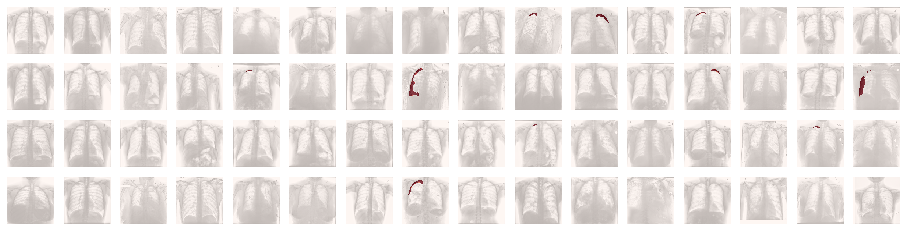

In [0]:
fns = glob2.glob('dataset/test/*.png')
preds = pneumothorax_model.predict(fns, tta = True)

plot_preds(fns, preds)
preds_to_csv(fns, preds)

### Predictions on the train set

94/94 [==============================] - 77s 820ms/step


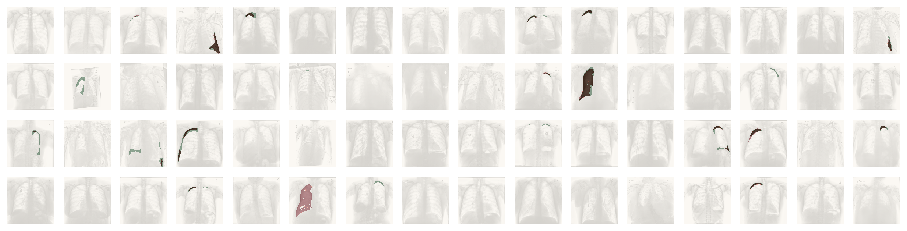

In [0]:
# not only on all the items because it would require too much RAM
fns = glob2.glob('dataset/train/*.png')[:3000]
preds = pneumothorax_model.predict(fns, tta = True)

plot_preds(fns, preds)
preds_to_csv(fns, preds)

In [0]:
# Sanity check on the .csv file
df = pd.read_csv(glob2.glob('preds_*.csv')[0])
df[df['EncodedPixels'] != '-1'].head()

,ImageId,EncodedPixels
8,ID_d966d30d0,169307 24 1000 25 993 32 992 32 970 54 969 55 ...
11,ID_2892d816e,392425 2 1022 3 1017 7 1017 8 1010 14 1010 15 ...
12,ID_db54d1349,300217 6 1018 6 1014 8 1016 8 1012 12 1012 12 ...
18,ID_6cca2c28c,601309 9 1014 11 1010 21 1003 22 980 50 974 50...
19,ID_87a258052,314658 15 1004 20 1003 24 995 30 993 32 989 35...


## (Optional) Ensembling model

Ensemble of two models:
- my best single model
- my best model on 768x768px images

Problem of RAM doesn't work yet

In [0]:
class PneumothoraxEnsemblingModel:
  """ Pneumothorax best single model
        Attributes: - param (dict): hyperparameters of the model
                    - model: keras model
        Functions:
                    - predict
  """
  def __init__(self, weights_path_model_1 = './weights/best_model_weights.model', weights_path_model_2 = './weights/second_model_weights.model'):
    """ Inputs: - Optional: weights_path_model_1 (str): path of the best model weights
                - Optional: weights_path_model_2 (str): path of the weights of best model on 768x768px images
    """
    self.param1, self.param2 = get_param_ensembling_inference(weights_path_model_1, weights_path_model_2)
    self.model1 = UEfficientNet(self.param1)
    self.model2 = UEfficientNet(self.param2)


  def predict(self, fns, tta = False):
    """ Predict the pneumothorax masks of a set of images.
        Inputs: - fns (str): paths of the image files
                - Optional: tta (bool): True if the model use Test Time Augmentation during the inference
        Return:
             - preds_refine (np.array): masks predictions
    """
    generator1 = InferenceGenerator(fns, self.param1)
    preds1 = self.model1.predict_generator(generator1, verbose = 1).astype(np.float16)
    # TTA
    if tta:
      generator_flipped = InferenceGenerator(fns, self.param1, horizontal_flip = True)
      preds_flipped = self.model1.predict_generator(generator_flipped, verbose = 1).astype(np.float16) # cast in float16 in order to avoid RAM issues
      preds_flipped = np.array([np.fliplr(x) for x in preds_flipped])
      preds1 = 0.5 * preds1 + 0.5 * preds_flipped
      del preds_flipped
    
    generator2 = InferenceGenerator(fns, self.param2)
    preds2 = self.model2.predict_generator(generator2, verbose = 1).astype(np.float16)
    # TTA
    if tta:
      generator_flipped = InferenceGenerator(fns, self.param2, horizontal_flip = True)
      preds_flipped = self.model2.predict_generator(generator_flipped, verbose = 1).astype(np.float16)
      preds_flipped = np.array([np.fliplr(x) for x in preds_flipped])
      preds2 = 0.5 * preds2 + 0.5 * preds_flipped
      del preds_flipped

    preds_refine = np.zeros((len(fns), 1024, 1024), dtype = np.uint8)
    for idx, (p1, p2) in enumerate(tqdm(zip(preds1, preds2))):
      p1 = cv2.resize(p1.squeeze(), (1024,1024))
      p2 = cv2.resize(p2.squeeze(), (1024,1024))
      p = (p1+p2)/2
      mask = p > self.param1['threshold_best']
      # zero out the smaller regions.
      num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
      predictions = np.zeros((1024, 1024), np.float32)
      for c in range(1, num_component):
        zone = (component == c)
        if zone.sum() > 2000: #min_size
          predictions[zone] = 1
      preds_refine[idx] = (predictions*255).astype(np.uint8)

    return preds_refine

def get_param_ensembling_inference(weights_path_model1, weights_path_model2):
  """ This function sets the hyperparameters of the ensembling model.
      Inputs: - weights_path_model1 (str): path of the best model weights
              - weights_path_model2 (str): path of the weights of best model on 768x768px images
      Return:
              - param1 (dict): parameters of the first model
              - param2 (dict): parameters of the second model
  """
  param1 = {}
  param1['weights_path'] = weights_path_model1
  param1['imgsize'] = 512
  param1['useGPU'] = True
  param1['batch_size'] = 32
  param1['threshold_best'] = 0.5
  param1['dropout_rate'] = 0.5
  param1['loss'] = None

  param2 = {}
  param2['weights_path'] = weights_path_model2
  param2['imgsize'] = 768
  param2['useGPU'] = True
  param2['batch_size'] = 16
  param2['threshold_best'] = 0.5
  param2['dropout_rate'] = 0.5
  param1['loss'] = None
  return param1, param2

In [0]:
weights_path_model_2 = repo_path_python + 'My_Model/Best Model 2/Unet++_EfficientNet_Model2.model'
pneumothorax_model = PneumothoraxEnsemblingModel(weights_path_model_1 = repo_path_python + 'single_model_weights.model', weights_path_model_2 = weights_path_model_2)

In [0]:
fns = glob2.glob('dataset/test/*.png')
preds = pneumothorax_model.predict(fns, tta = True)
plot_preds(fns, preds)
preds_to_csv(fns, preds)